## 1. Import packages

In [3]:
import requests
import pandas as pd   
import numpy as np 
import datetime
import time

## 2. Define function to get coin data from API

In [2]:
#Source: https://blog.cryptocompare.com/cryptocompare-api-quick-start-guide-f7abbd20d260
    
#This function establishes a request to the online plattform BitFinex:
def get_data_spec(coin, date, time_period):
    """ Query the API for the historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&e=BitFinex&tsym=USD&toTs={}".format(time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

#This function collects the cryptocurrency data from for the specified time period: 
def get_df_spec(time_period, coin, from_date, to_date):
    """ Get historical price data between two dates. If further apart than query limit then query multiple times. """
    date = to_date
    
    holder = []
    while date > from_date:
        # Now we use the new function to query specific coins
        data = get_data_spec(coin, date, time_period) 
        holder.append(pd.DataFrame(data["Data"]))
        date = data['TimeFrom'] 
        

def compute_Returns(data):
    data["Average_price"]=(data["close"]+data["open"])/2
    data["returns"]=data["Average_price"].divide(data["Average_price"].shift())-1
    data= data.iloc[1:] 
    return data

## 3. Get hourly data for 12 coins according to steady coin study, time period 17/18 six month

In [11]:
coins = ['BTC', 'ETH', 'XRP' ,'BCH', 'LTC' ,'EOS' ,'XMR', 'NEO', 'MIOTA', 'DASH', 'ETC','ZEC'] 

In [ ]:
%%time
hourly_df  = {}

start_unix = time.mktime(datetime.datetime.strptime("01/05/2019", "%d/%m/%Y").timetuple())
end_unix   = time.mktime(datetime.datetime.strptime("01/11/2019", "%d/%m/%Y").timetuple())

errorcoin  = [] # for coins with no data avaliable  

for coin in coins:
    try:
        hourly_df[coin] = compute_Returns(get_df_spec('histohour',coin,  start_unix, end_unix))
    except:
        print(coin + ': error')
        errorcoin.append(coin)

### 3.1. New API for ZEC

In [5]:
import bitfinex
#Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2()
result = api_v2.candles()

No keys, only access to public API functions


In [6]:
coins = pd.Series(coins).apply(lambda x :x.lower())

In [7]:
%%time
c = 'zec'
pair = c+'usd'  # Currency pair of interest
bin_size = '1h' # This will return minute data
limit = 5000    # We want the maximum of 5000 data points 
# Define the start date
t_start = datetime.datetime(2017, 11, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000
# Define the end date
t_stop    = datetime.datetime(2018, 5, 1, 0, 0)
t_stop    = time.mktime(t_stop.timetuple()) * 1000

pair_data = api_v2.candles(symbol=pair, interval=bin_size,  
                           limit=limit, start=t_start, end=t_stop)

import pandas as pd

# Create pandas data frame and clean/format data
names = ['time', 'open', 'close', 'high', 'low', 'volume']
df = pd.DataFrame(pair_data, columns=names)
df.drop_duplicates(inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='ms')
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

CPU times: user 54.5 ms, sys: 5.96 ms, total: 60.5 ms
Wall time: 460 ms


In [16]:
zec = compute_Returns(df)
hourly_df['ZEC'] = zec

In [23]:
zec

,open,close,high,low,volume,Average_price,returns
time,,,,,,,
2017-11-01 00:00:00,232.96,231.00,234.02,230.39,479.177701,231.980,-0.005189
2017-11-01 01:00:00,230.99,231.09,231.66,228.82,409.477664,231.040,-0.004052
2017-11-01 02:00:00,230.25,230.43,231.54,229.51,122.662979,230.340,-0.003030
2017-11-01 03:00:00,230.42,228.88,230.87,228.01,621.325692,229.650,-0.002996
2017-11-01 04:00:00,229.46,227.55,229.47,227.33,551.834344,228.505,-0.004986
...,...,...,...,...,...,...,...
2018-04-30 18:00:00,288.64,287.22,290.60,287.02,348.976872,287.930,0.001827
2018-04-30 19:00:00,288.11,290.17,290.51,286.28,205.714753,289.140,0.004202
2018-04-30 20:00:00,290.27,289.12,292.00,288.84,248.341325,289.695,0.001919


## 4. Merge columns for different coins

In [28]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [29]:
hourlyPrice = merge_dfs_on_column(list(hourly_df.values()), list(hourly_df.keys()), 'Average_price')

hourlyReturn= merge_dfs_on_column(list(hourly_df.values()), list(hourly_df.keys()),'returns')

In [ ]:
hourlyPrice.to_csv('1718hourlyPrice_withZEC.csv')
hourlyReturn.to_csv('1718hourlyReturn_withZEC.csv')

## 5. Macro Index 

### S&P 500

S&P 500 index get in https://www.investing.com

In [4]:
sp500 = pd.read_csv('./S&P 500 Historical Data.csv')

from datetime import datetime
# convert str to datetime
sp500.Date = sp500.Date.apply(lambda x: pd.to_datetime(datetime.strptime(x, '%b %d, %Y')))

# generate hourly time index 
time_idx = pd.date_range(sp500.Date.iloc[-1], sp500.Date[0], freq="1h")

# set time as index
sp500.set_index('Date',inplace=True)

# reverse dataframe, now the date is ascending
sp500 = sp500[::-1]

In [5]:
# because sp500 is daily data and only for work days
# create new df with new hourly idx
df         = pd.DataFrame(time_idx)
df.columns =['Datetime']
df.set_index('Datetime',inplace=True)
df['sp500']= sp500['Price']
# fill nan with prescending value 
df = df.fillna(method='ffill')

In [6]:
df['sp500']=df['sp500'].str.replace(',', '')
df.sp500   = df.sp500.astype(float)

In [7]:
# calculate return

sp500RT = df["sp500"].divide(df["sp500"].shift())-1
df['sp500RT']=sp500RT

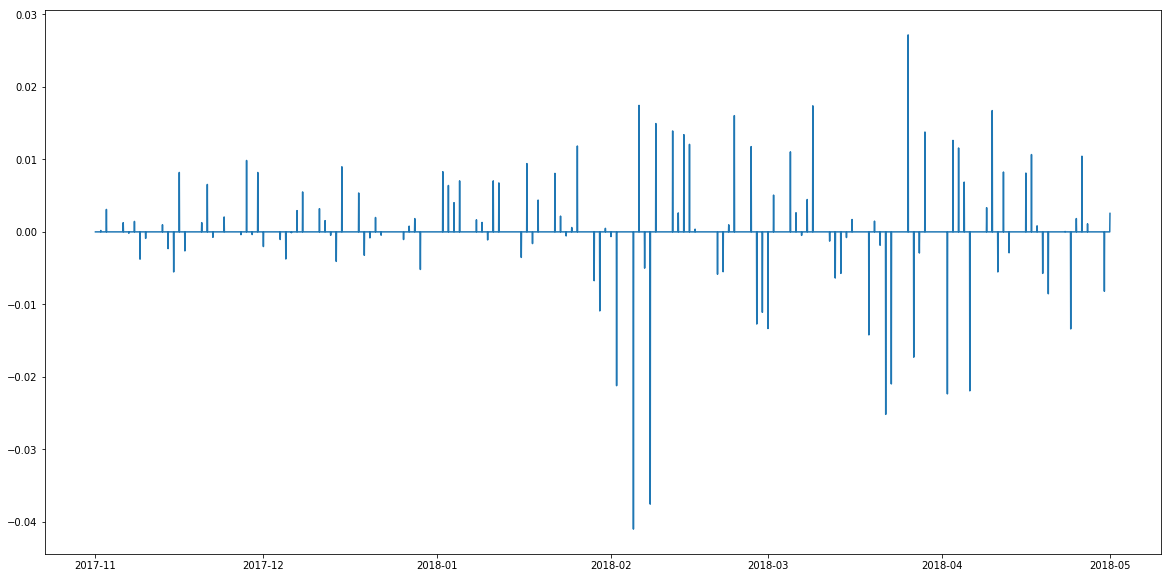

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
plt.plot(sp500RT)

### VIX

http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data

In [10]:
vix = pd.read_csv('./vixcurrent.csv')
vix.columns = vix.iloc[0].values
vix.drop(0,inplace=True)
vix.Date =vix.Date.apply(lambda x: pd.to_datetime(datetime.strptime(x, '%m/%d/%Y')))
vix.set_index('Date',inplace= True)
vix = vix.astype(float)
vix['Price'] =(vix['VIX Open']+vix['VIX Close'])/2

In [11]:
df['vix']=vix['Price']
# fill nan with prescending value 
df = df.fillna(method='ffill')

In [12]:
vixRT = df["vix"].divide(df["vix"].shift())-1
df['vixRT']=vixRT

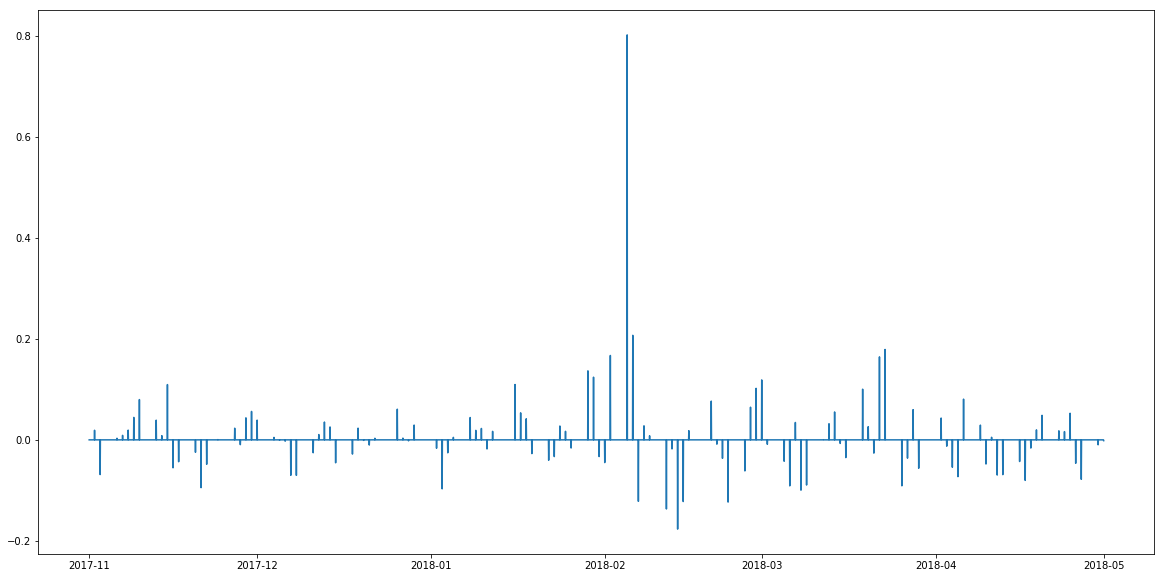

In [13]:
plt.figure(figsize=[20,10])
plt.plot(vixRT)

In [14]:
df = df.fillna(method='bfill')

In [15]:
df.head()

,sp500,sp500RT,vix,vixRT
Datetime,,,,
2017-11-01 00:00:00,2579.36,0.0,9.995,0.0
2017-11-01 01:00:00,2579.36,0.0,9.995,0.0
2017-11-01 02:00:00,2579.36,0.0,9.995,0.0
2017-11-01 03:00:00,2579.36,0.0,9.995,0.0
2017-11-01 04:00:00,2579.36,0.0,9.995,0.0


In [21]:
df.iloc[:,[0,2]].to_csv('./macro1718.csv')

In [22]:
df.iloc[:,[1,3]].to_csv('./macro1718_return.csv')